# Logistic Regression

In [ ]:
#import the neceessary packages
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt 

In [ ]:
#read the csv file and get some info 
df = pd.read_csv('college_student_placement_dataset.csv')
df.info(5)

In [ ]:
df['Placement'].value_counts()

## Preprocessing 
1. As the placement feature has more than 80 percent of no makes the the yes a minority feature. So we use SMOTE to balance the dataset 
2. We have College_ID feature with a lot of unique values. so we use target encoding to encode them 
3. For the internship experience feature we use one hot encoding 
4. Both test and train datasets have two different preprocessing fucntions to avoid data sharing between the sets 

In [7]:
def preprocess_train(X_train, y_train):
    X_train_proc = X_train.copy()
    y_train_proc = y_train.copy()
    #cgpa which is higher than 10 will be replaced by the mean of cgpa 
    #after converting values higher than 10 into null.the added values are now converted into floating point
    X_train_proc.loc[X_train_proc['CGPA'] > 10, 'CGPA'] = np.nan
    cgpa_mean_val = X_train_proc['CGPA'].mean()
    X_train_proc.fillna({'CGPA': cgpa_mean_val}, inplace=True)
    X_train_proc['CGPA'] = pd.to_numeric(X_train_proc['CGPA'], errors='coerce')
    
    #CollegeID is encoded using target encoding method where placement coloumn is encoded for integer values 
    temp_df = X_train_proc.copy()
    temp_df['Placement_Target'] = y_train_proc
    target_encoding_map = temp_df.groupby('College_ID')['Placement_Target'].mean()
    X_train_proc['College_ID'] = X_train_proc['College_ID'].map(target_encoding_map)
    
    #Internship_experience is also a categorical value
    X_train_proc = pd.get_dummies(X_train_proc, columns=['Internship_Experience'], drop_first=True)
    
    #Oversampling for Placement values as Yes is a minority in the dataset with only 17%
    counts = y_train_proc.value_counts()
    majority_count = counts.max()
    minority_count = counts.min()
    minority_class = counts.idxmin()
    
    n_duplicates_needed = majority_count - minority_count
    
    X_minority = X_train_proc[y_train_proc == minority_class]
    y_minority = y_train_proc[y_train_proc == minority_class]

    X_oversampled = X_minority.sample(n=n_duplicates_needed, replace=True, random_state=42)
    y_oversampled = y_minority.sample(n=n_duplicates_needed, replace=True, random_state=42)

    X_train_proc = pd.concat([X_train_proc, X_oversampled])
    y_train_proc = pd.concat([y_train_proc, y_oversampled])
    
    return X_train_proc, y_train_proc, cgpa_mean_val, target_encoding_map
    

In [8]:
def preprocess_test(X_test, cgpa_mean_val, target_encoding_map):
    X_test_proc = X_test.copy()
    #cgpa which is higher than 10 will be replaced by the mean of cgpa 
    #after converting values higher than 10 into null.the added values are now converted into floating point
    X_test_proc.loc[X_test_proc['CGPA'] > 10, 'CGPA'] = np.nan
    X_test_proc.fillna({'CGPA':cgpa_mean_val}, inplace=True)
    X_test_proc['CGPA'] = pd.to_numeric(X_test_proc['CGPA'], errors='coerce')
    
    #CollegeID is encoded using target encoding method where placement coloumn is encoded for integer values 
    global_mean = target_encoding_map.mean()
    X_test_proc['College_ID'] = X_test_proc['College_ID'].map(target_encoding_map).fillna(global_mean)
    
    #Internship_experience is also a categorical value
    X_test_proc = pd.get_dummies(X_test_proc, columns=['Internship_Experience'], drop_first=True)
    
    return X_test_proc

In [9]:
x = df.drop('Placement', axis=1)
y = df['Placement'].map({'No':0, 'Yes':1})

## StratifiedKFold
As we introduced a lot of duplicate data it is important the split happens without any imbalance, so to prevent that we use a cross validation technqiue called StratifiedKFold

In [10]:
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1_scores = []
train_accuracies = []
val_accuracies = []
print(f"Starting Stratified {N_SPLITS}-Fold Cross-Validation with Preprocessing Pipelining...")
print("-" * 70)

Starting Stratified 5-Fold Cross-Validation with Preprocessing Pipelining...
----------------------------------------------------------------------


After the split we create a for loop for every fold and fit and train the model. Then we use visualization techniques to see if there is any overfitting 

0.01666187050359713
0.015556046755582198
0.009107897497377504
0.015007043308856605
0.015132399220740278

Average Accuracy: 0.8465


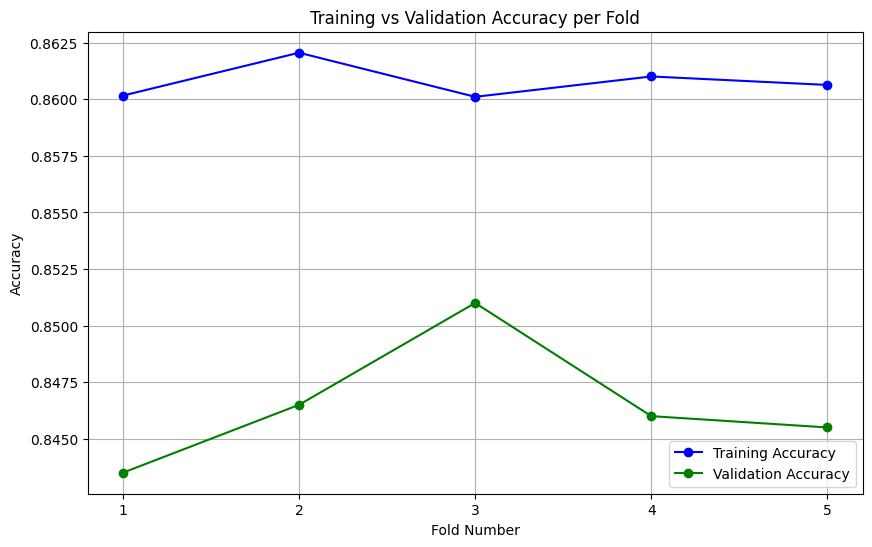


--- Summary ---
Average Training Accuracy:   0.8608
Average Validation Accuracy: 0.8465
✅  Model is generalizing well (Train ≈ Val)


In [11]:
for fold, (train_index, val_index) in enumerate(skf.split(x, y), 1):
    X_train_raw, X_test_raw = x.iloc[train_index], x.iloc[val_index]
    y_train_raw, y_test = y.iloc[train_index], y.iloc[val_index]
    
    try:
        X_train_proc, y_train_proc, cgpa_mean, enc_map = preprocess_train(X_train_raw, y_train_raw)
        X_test_proc = preprocess_test(X_test_raw.copy(), cgpa_mean, enc_map)
        
        X_test_proc = X_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)
    
        model = LogisticRegression(solver='liblinear', random_state=42)
        model.fit(X_train_proc, y_train_proc)
        y_pred = model.predict(X_test_proc)
        
        accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(accuracy)
    
        train_acc = accuracy_score(y_train_proc, model.predict(X_train_proc))
        val_acc = accuracy_score(y_test, model.predict(X_test_proc))
    
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
    
        diff = train_acc - val_acc
        print(diff)
    except Exception as e :
        print(f"error during{fold}. Skipping this feild{e} ")
        continue
print(f"\nAverage Accuracy: {np.mean(fold_accuracies):.4f}")
    
results_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Training Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies
})

if len(train_accuracies) < 5:
    print("\nWarning: Not all 3 folds completed. Visualization may be inaccurate.")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df['Fold'], results_df['Training Accuracy'], marker='o', label='Training Accuracy', color='blue')
plt.plot(results_df['Fold'], results_df['Validation Accuracy'], marker='o', label='Validation Accuracy', color='green')

plt.title('Training vs Validation Accuracy per Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.show()

avg_train = np.mean(train_accuracies)
avg_val = np.mean(val_accuracies)
print("\n--- Summary ---")
print(f"Average Training Accuracy:   {avg_train:.4f}")
print(f"Average Validation Accuracy: {avg_val:.4f}")

if (avg_train - avg_val) > 0.05:
    print("⚠️  Warning: Potential Overfitting detected (Train >> Val)")
else:
    print("✅  Model is generalizing well (Train ≈ Val)")